# TensorTools Runtime Demo

Demonstrates the usage of the runtime using a simple autoencoder model.

In [1]:
# Force matplotlib to use inline rendering
%matplotlib inline

import os
import sys

# add path to libraries for ipython
sys.path.append(os.path.expanduser("~/libs"))

import numpy as np
import tensorflow as tf
import tensortools as tt

In [2]:
BATCH_SIZE = 24
REG_LAMBDA = 5e-4
NUM_GPUS = 2

In [3]:
dataset_train = tt.datasets.moving_mnist.MovingMNISTTrainDataset(BATCH_SIZE * NUM_GPUS,
                                                                 input_seq_length=1, target_seq_length=0)
dataset_valid = tt.datasets.moving_mnist.MovingMNISTValidDataset(BATCH_SIZE * NUM_GPUS,
                                                                 input_seq_length=1, target_seq_length=0)
#dataset_test = tt.datasets.moving_mnist.MovingMNISTTestDataset(BATCH_SIZE * NUM_GPUS,
#                                                               input_seq_length=1, target_seq_length=0)

File mnist.h5 has already been downloaded.
File mnist.h5 has already been downloaded.


In [3]:
dataset_train = tt.datasets.mnist.MNISTTrainDataset(BATCH_SIZE)
dataset_valid = tt.datasets.mnist.MNISTValidDataset(BATCH_SIZE)
#dataset_test = tt.datasets.moving_mnist.MovingMNISTTestDataset(BATCH_SIZE * NUM_GPUS,
#                                                               input_seq_length=1, target_seq_length=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


AttributeError: 'DataSet' object has no attribute 'shape'

In [4]:
class SimpleAutoencoderModel(tt.model.AbstractModel):    
    def __init__(self, reg_lambda=0.0):
        super(SimpleAutoencoderModel, self).__init__(reg_lambda)
        
    @tt.utils.attr.override
    def inference(self, inputs, targets, is_training=True,
                  device_scope=None, memory_device=None):
        input_shape = inputs.get_shape()
        
        x = tf.contrib.layers.flatten(inputs)
        encoded = tt.network.fc("FC_Enc", x, 128,
                                weight_init=tf.contrib.layers.xavier_initializer(),
                                bias_init=0.0,
                                activation=tf.nn.relu,
                                device=memory_device)
        representation = encoded
        decoded = tt.network.fc("FC_Dec", representation, int(np.prod(input_shape[1:4])),
                                weight_init=tf.contrib.layers.xavier_initializer(),
                                bias_init=0.0,
                                activation=tf.nn.sigmoid,
                                device=memory_device)

        return tf.reshape(decoded, [-1, 1, input_shape[2].value, input_shape[3].value, input_shape[4].value])
    
    @tt.utils.attr.override
    def loss(self, predictions, targets):
        return tt.loss.bce(predictions, targets)

In [5]:
#runtime = tt.core.MultiGpuRuntime(NUM_GPUS)
runtime = tt.core.DefaultRuntime()
runtime.register_datasets(dataset_train, dataset_valid)
runtime.register_model(SimpleAutoencoderModel(reg_lambda=REG_LAMBDA))
runtime.build(is_autoencoder=True)

Launing default runtime...


In [6]:
runtime.train(steps=5000)

Starting epoch 1...
@    10: loss:     0.689, total-loss:     0.689 ( 1201.5 examples/sec,  0.04 sec/batch)
@    20: loss:     0.674, total-loss:     0.674 ( 1540.2 examples/sec,  0.03 sec/batch)
@    30: loss:     0.640, total-loss:     0.640 ( 1451.0 examples/sec,  0.03 sec/batch)
@    40: loss:     0.581, total-loss:     0.581 ( 1405.4 examples/sec,  0.03 sec/batch)
@    50: loss:     0.497, total-loss:     0.497 ( 1557.6 examples/sec,  0.03 sec/batch)
@    60: loss:     0.404, total-loss:     0.404 ( 1576.8 examples/sec,  0.03 sec/batch)
@    70: loss:     0.329, total-loss:     0.329 ( 1564.3 examples/sec,  0.03 sec/batch)
@    80: loss:     0.272, total-loss:     0.272 ( 1543.9 examples/sec,  0.03 sec/batch)
@    90: loss:     0.237, total-loss:     0.237 ( 1598.3 examples/sec,  0.03 sec/batch)
@   100: loss:     0.216, total-loss:     0.216 ( 1540.1 examples/sec,  0.03 sec/batch)

@   100: Starting validation (batch-size: 48, dataset-size: 10000):
9984/9984 [====================

KeyboardInterrupt: 

In [ ]:
runtime.validate()

In [ ]:
runtime.test()

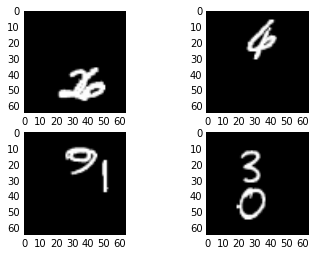

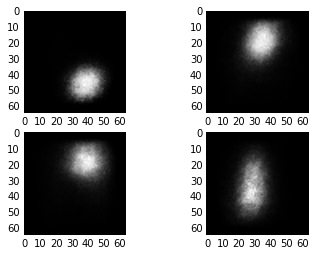

In [7]:
batch_x, _ = dataset_valid.get_batch()

predictions = runtime.predict(batch_x)

tt.visualization.display_batch(batch_x[0:4,0,:,:,:])
tt.visualization.display_batch(predictions[0:4,0,:,:,:])

In [ ]:
runtime.close()